# 3.10.2 - Advanced - Geospatial Analysis

## Outline

### Prerequisites

-   Geospatial Analysis 1
-   Intermediate R skills
-   Theoretical understanding of multiple regression
-   Basic geometry

### Outcomes

After completing this notebook, you will be able to:

-   Manipulate geospatial objects in R using the `sf` package.
-   Perform geospatial operations on real world data.
-   Use the `sf` package to read in shapefile data from online sources.
-   Calculate distances using geospatial operations.
-   Understand applications of geospatial analysis in the context of
    economic research.

### References

-   [Geocomputation with R](https://r.geocompx.org/intro)
-   Disdier, Anne-Célia, and Keith Head. “The Puzzling Persistence of
    the Distance Effect on Bilateral Trade.” The Review of Economics and
    Statistics, 2008.
-   Pebesma, E., & Bivand, R. (2023). [Spatial Data Science: With
    Applications in R.](https://r-spatial.org/book/)
-   Tinbergen, J. (1962) Shaping the World Economy: Suggestions for an
    International Economic Policy. The Twentieth Century Fund, New York.
-   

## Introduction

In this notebook, we’ll continue our discussion of geospatial analysis
with vector data. We’ll use trade data and shapefiles from Statistics
Canada for our examples.

In [ ]:
# load packages
library(tidyverse)
library(ggplot2)
library(sandwich)
library(lmtest)
library(sf)
library(spData)
library(rmapshaper)
library(crsuggest)

## Part 1: Understanding Geospatial Data

> **Note**: geospatial files tend to be quite large and we use `for`
> loops in this notebook. It is possible that the code takes a while to
> run successfully.

### File types and sizes

In the previous notebook, we only worked with user-generated data and
with datasets embedded in the package `spData`. It’s likely that for
your applications, you’ll have to work with external geospatial files.

The most common of geospatial file type is the **ESRI Shapefile** for
vector data. This file has the extension `.shp` and typically comes in a
zipped folder with at least three associated files. The `sf` function to
read shapefiles is `read_sf("filename.shp")`. There are many places to
find shapefiles online. Some good places to look include
[Geocommons](http://geocommons.com/), [Natural
Earth](https://www.naturalearthdata.com/), and [Living
Atlas](https://livingatlas.arcgis.com/en/browse/#d=2).

Other common file types for vector data include:

-   GeoJSON (`.geojson`): extension of JSON file, mostly used for
    storing latitude and longitude coordinates.
-   ESRI FileGDB (`.gdb`): stores objects created by ArcGIS (a popular
    software for geospatial analysis.
-   GeoPackage (`.gpkg`): lightweight, platform-independent, and compact
    format.

It’s important to keep in mind that these files come in varying forms
and sizes. It’s very common for shapefiles to be extremely detailed and
highly-defined, which can exponentially increase the file size and
runtime of your analysis. The function `ms_simplify()` from the package
`rmapshaper` simplifies shapefiles by reducing the number of vertices of
the spatial objects while maintaining the integrity of the shapes.

Let’s read a shapefile of Canadian provinces and plot them on a map with
the attribute `province`.

In [ ]:
shape <- read_sf("advanced_geospatial_datasets/advanced_geospatial_datasets.shp")

shape_plot <- plot(shape["province"])

Zoom in on the province boundaries and look at how detailed they are.
We’re likely not going to need this level of detail for our analysis, so
let’s simplify the file to avoid large runtimes. We’ll do so by using
the function `ms_simplify()` to reduce the number of vertices to 1% of
our current number.

In [ ]:
# run the code below to learn more about the function ms_simplify()
# ?ms_simplify

In [ ]:
# keep parameter indicates % of vertices to keep
canada_shape <- ms_simplify(shape, keep = 0.01, keep_shapes = TRUE)

In [ ]:
plot(canada_shape["province"])

Note how now we have simplified the boundaries of the provinces. We can
use the function `object.size()` to compare how much memory we’re saving
by using our `canada_shape` instead of the large `shape` object.

In [ ]:
object.size(canada_shape)
object.size(shape)

> **Note**: the object `shape` was already a simplified version of the
> high-definition shapefiles on the Statistics Canada website.
> Performing basic geospatial operations on those files could take
> multiple *minutes*!

### Choosing an appropriate CRS

As explained in our previous notebook, a CRS is the grid of reference
for our geographic objects. These grids can be either **geographic**,
coded in spherical longitude and latitude coordinates, or **projected**,
coded in planar (x,y) coordinates.

The manner in which we identify the CRS is through a parameter of the
form `AUTHORITY:CODE`. In the previous notebook, we used the identifier
`EPSG:4326` to refer our geometric objects to the CRS WGS84, which is
the most popular geographic CRS worldwide. When choosing a geographic
CRS, you typically cannot go wrong with WGS84.

Choosing a projected CRS is often a tricky task - it depends on how you
plan on using it. When projecting a geographic CRS, there will
unavoidably be distortions to either the distances or the areas of the
projected objects. The most common types of projections include:

-   **Lambert azimuthal equal-area (LAEA) projections**: preserve
    equal-area at all locations but distorts shapes beyond thousands of
    kilometers.
-   **Azimuthal equidistant (AEQD) projections**: maintain accurate
    straight-line distance between a point and the center point of the
    projection.
-   **Lambert conformal conic (LCC) projections**: the cone is set to
    keep distance and area properties reasonable, which is useful for
    regions covering thousands of kilometers.
-   **Stereographic (STERE) projections**: projections for polar
    regions, but with distortions on areas and distances thousands of
    kilometers from the center.

The package `crsuggest` has a function `suggest_crs()`, which takes a
spatial object with a geographic CRS and returns a list of possible
projected CRS’s that could be used for the given object.

We can use the function `st_crs()` to find out the CRS of our objects
and `st_transform()` to change the CRS of the object.

In [ ]:
# run the cell to get information from the CRS
print(st_crs(canada_shape))
st_crs(canada_shape)$IsGeographic
st_crs(canada_shape)$units_gdal

From the output above we can see that `canada_shape` is in a geographic
CRS called NAD83. This geographic CRS is customized to North America and
has an `AUTHORITY:CODE` of `EPSG:4269`.

### Using S2 for operations in spherical coordinates

Now that we’ve looking in more detail at CRS’s, it’s time to introduce
`S2`. `S2` is a dependency of the `sf` package and is used for geometric
operations on spherical coordinates (i.e., when the CRS is in longitude
and latitude coordinates). `S2` setups are especially important when
calculating distances or setting buffers around objects.

This is better illustrated with an example. Let’s suppose we want to
draw a buffer of distance 10 meters around the province of Alberta.
Let’s perform this operation on our `canada_shape` dataset, first with
`S2` turned on and then with `S2` turned off.

In [ ]:
# turn on `S2`
sf_use_s2(TRUE)

# define Alberta
alberta <- canada_shape[canada_shape$province == "Alberta", ]

plot(st_buffer(alberta, dist = 10))

In [ ]:
# turn off `S2`
sf_use_s2(FALSE)

# define Alberta
alberta <- canada_shape[canada_shape$province == "Alberta", ]

plot(st_buffer(alberta, dist = 10))

Notice the difference? That happens because when `S2` is turned off, the
operation is performed in *degrees* and not in meters. Since the length
of degrees change according to the longitude and latitude of the object,
the buffers won’t be equidistant to the borders.

Now, let’s try to calculate the distance between Alberta and Ontario
with `S2` turned on and off.

In [ ]:
# turn on `S2`
sf_use_s2(TRUE)

# calculate distance
alberta <- canada_shape[canada_shape$province == "Alberta", ]
ontario <- canada_shape[canada_shape$province == "Ontario", ]

st_distance(alberta, ontario)

In [ ]:
# turn off `S2`
sf_use_s2(FALSE)

# calculate distance
alberta <- canada_shape[canada_shape$province == "Alberta", ]
ontario <- canada_shape[canada_shape$province == "Ontario", ]

st_distance(alberta, ontario)

Notice that when `S2` is turned off, we get a very different number. The
main takeaway is that we should use `S2` when applying geospatial
operations to objects with geographic coordinates.

The diagram below shows how R uses `S2` for geometric operations.

<figure>
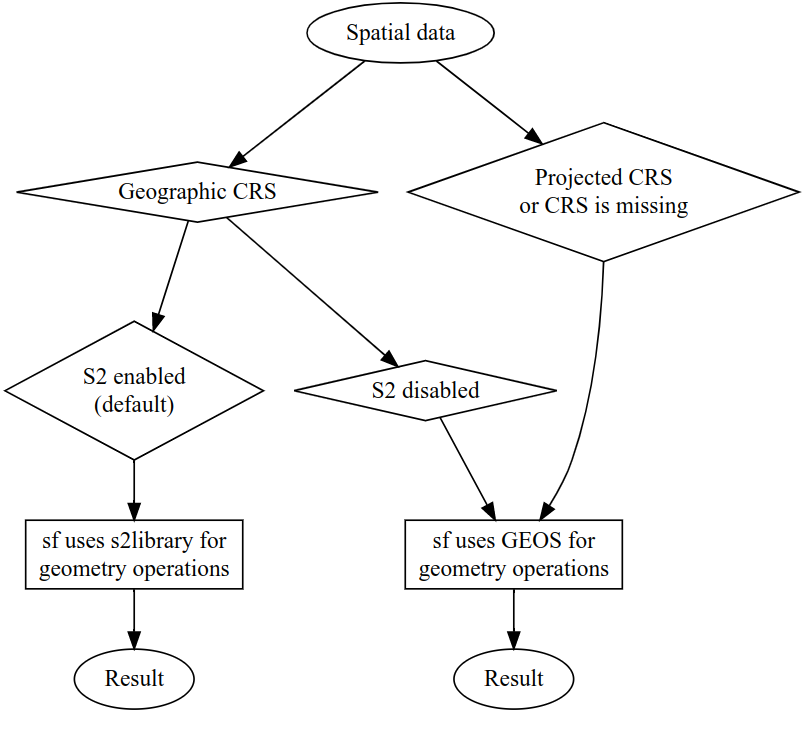
<figcaption aria-hidden="true">Lovelace, Robin and Nowosad, Jakub and
Muenchow, Jannes, (2019). Geocomputation with R.</figcaption>
</figure>

Let’t turn `S2` back on for the remainder of our analysis.

In [ ]:
sf_use_s2(TRUE)

## Part 2: Gravity Equation of Trade

### Theory

In the 1660’s, Isaac Newton formalized the law of gravity: particles
attract each other with a force that is proportional to the product of
their masses and inversely proportional to the square of their distance.
In 1962, Dutch economist Jan Tinberg adapted the law of gravity to
international trade. Tinberg (1962) proposed that the aggregate trade
flows between any two countries is “proportional to the gross national
products of those countries and inversely proportional to the distance
between them.” Mathematically, that means

$$
Trade = G \frac{Mass_{1}^\alpha Mass_{2}^\beta}{Distance^\theta}
$$

Since then, there have been numerous attempts to estimate the effects of
both economic mass and distance on trade flows empirically. By taking
logs of both sides of the equation, we can show that the gravity
equation translates to

$$
log(Trade) = log(G) + \alpha log(Mass_{1}) + \beta log(Mass_{2}) - \theta log(Distance)
$$

In this section, we’ll try to estimate the effect of distance on trade
flows using data from Canadian provinces and US states.

### Empirical Methods

Empirically, we can estimate the effect of distance on trade with an
adaptation of the model above. For a Canadian province $i$ and a US
state $j$:

$$
log(T_{ij}) = \beta_{0} + \beta_{1} log(Y_{j}) - \beta_{2} log(X_{ij}) + \sum_{i=2}^{13} \gamma_{i} D_{i} + \epsilon
$$

where

-   $T_{ij}$ is total merchandise volume between province $i$ and state
    $j$
-   $Y_{j}$ is the GDP of state $j$
-   $X_{ij}$ is the distance between province $i$ and state $j$
-   $D_{i}$ is a dummy for province $i$

This specification is similar to the traditional gravity equation; by
controlling for provinces with dummy variables, we implicitly control
for the economic masses of those provinces.

The effect of interest is the coefficient on distance, $\beta_{2}$,
which can be interpreted as trade elasticity: the percentage change in
total merchandise volume from a 1% change in distance.

### Data Cleaning and Wrangling

We have three datasets for this analysis: `canada_shape`, `us_states`,
and `trade_data`. The first 2 datasets contain the shapefiles of
Canadian provinces and US states, and the last file contains trade data
from Statistics Canada. Let’s load our datasets.

In [ ]:
# load trade data
trade_data <- read_csv("advanced_geospatial_datasets/trade_data.csv")
head(trade_data)

# view canada_shape (we've loaded it in the previous section)
head(canada_shape)

# view us_states (comes with spData package)
head(us_states)

By looking at the “trade_data” dataset, we see that:

-   We already have data on total merchandise volume
    (`tmerch_value_usd`) between provinces and states
-   We already have data on the GDP of US states (`gdp`)
-   We can easily create dummies for each Canadian province with the
    column `province`

Therefore, the only variable missing for our specification is the
distance between each province-state pair. We can use our shapefiles to
calculate the distance between provinces and states with the function
`st_distance` from the `sf` package.

We want a dataset with the following structure:

| Province | State | Total Merchandise Volume (USD) | State GDP (USD) | Distance (Km) |
|---------------|:-------------|------------------:|:------------:|:----------:|
| Alberta | Alabama | USD | USD | Km |
| Alberta | Arkansas | USD | USD | Km |
| Alberta | Arizona | USD | USD | Km |

The easiest way to do this is by creating an `sf` object with the
distance values, and then merging it with `trade_data` using the fields
`province` and `state`.

Before we do that, let’s take a look at the CRS of our shapefiles.

In [ ]:
# look at CRS details
st_crs(canada_shape)$WktPretty #WktPretty makes it easier to see the CRS parameters
st_crs(us_states)$WktPretty

Our objects reference the same CRS - the geographic NAD83 CRS. We could
just go ahead and calculate the distance between our objects (as long as
our `S2` is turned on!); however, for learning purposes, let’s take a
look at the projected suggestions from the function `suggest_crs()`.

In [ ]:
# find list of suggested CRS
suggest_crs(canada_shape, type = "projected", units = "m") #note that the units must be in metres instead of km
suggest_crs(us_states, type = "projected", units = "m")

This is quite an extensive list of candidates for our projected CRS. As
you can see, the suggested CRS are very specific to the center of the
geographic CRS - most of the suggested CRSs for Canada are artic/polar,
while for the US they are based in Minnesota. Since our datasets are
already in the same CRS, let’s stick with that.

In [ ]:
# selecting the columns we'll need from `us_states`
us_shape <- us_states %>%
            select(state = NAME, geometry) 

Let’s plot our shape files on a map and then turn to merging our
datasets.

In [ ]:
plot(canada_shape["province"], reset = FALSE)
plot(us_shape["state"], add = TRUE)

### Creating our `sf` Object for the Distances

Since our shapefiles are in two separate files, the approach we’re going
to take is:

1.  Create a vector with the labels `province` and `state`
2.  Create a vector with the `distance` between each province-state pair
3.  Merge those vectors together in a dataframe
4.  Inner join the dataframe with the `trade_data` file

By approaching the data wrangling step-by-step, we can see exactly what
is going on and can check our work each step of the way. This is often
preferred when working with multiple datasets and merging through
variables that are not factors (we have to merge datasets through
province-state names!).

Let’s start with Step (1). We’ll create nested `for` loops, indexing
provinces with `i` and states with `j`. Follow the comments of the code.

In [ ]:
province_num <- nrow(canada_shape)    # each entry of `canada_shape` is a province
states_num <- nrow(us_shape)    # each entry of `us_shape` is a state

prov_state_vec <- c()    # create a placeholder vector that will contain the `province - state` pairs
for (i in 1:province_num){    # start the loop with a province i, from a set of 1 to `province_num` provinces
    prov_i <- canada_shape$province[i]    # select province name indexed by i

    for (j in 1:states_num){    # for the selected province i, loop through the states, indexed by j
        state_j <- us_shape$state[j]    # select state name indexed by j
        prov_state_pair <- paste(prov_i, "-", state_j)    # paste prov i and state j as a string separated by a dash
        prov_state_vec <- append(prov_state_vec, prov_state_pair)    # append the `province-state` pair "i - j" to the placeholder vector
    }    # close state loop for state j and repeat process for state j + 1 
}    # close province loop for province i and repeat process for province i + 1
head(prov_state_vec)

Let’s check if our loop worked as intended. We have 13 provinces and 49
states, so we should have a total of $(13)(49) = 637$ province-state
pairs.

> **Note**: you can check the number of provinces and states by running
> `nrow(canada_shape)` and `nrow(us_shape)`. We’re missing Hawaii and
> Alaska, and we’re counting the District of Columbia as a state.

In [ ]:
length(prov_state_vec)

It looks like it worked! Now to Step 2. We repeat the same process, but
instead of pasting strings, we calculate the distance between province
`i` and state `j`. As noted earlier, our projected CRS is in meters, so
those are the units of our distances.

> **Note**: this operation might take a while to run.

In [ ]:
province_num <- nrow(canada_shape)
states_num <- nrow(us_shape)

distance_vec <- c()
for (i in 1:province_num){
    geo_prov_i <- st_make_valid(canada_shape$geometry[i])    # retrieve province geometry and adjust polygons with multiple vertices

    for (j in 1:states_num) {
        geo_state_j <- st_make_valid(us_shape$geometry[j])    # retrieve state geometry and adjust polygons with multiple vertices
        distance <- as.double(st_distance(geo_prov_i, geo_state_j))    # calculate distance in meters
        distance_vec <- append(distance_vec, distance)
   }
   
}
head(distance_vec)

Do you see the distances? For Step 3, let’s merge both vectors into a
dataframe with `cbind`, and then separate the state and province match
into 2 columns with `separate_wider_delim`.

In [ ]:
# merging distance files
distance_data <- as.data.frame(cbind(prov_state_vec, distance_vec)) %>%
                separate_wider_delim(prov_state_vec, names = c("province", "state"), delim = "-") %>%
                mutate(province = trimws(province), state = trimws(state), distance_m = as.numeric(distance_vec)) %>%    # trimming white-space
                select(-distance_vec)
head(distance_data)

> **Note**: The reason we are able to use `cbind()` to merge the two
> dataframes without a unique identifier is because they are ordered
> exactly the same. Our two `for` loops create pairs in an identical
> manner, so the distance pairs will ordered the same as our
> province-state pairs. We would not be able to do this is if they were
> ordered differently!

As a sanity check, let’s calculate the number of pairs per province
(each province should be paired with exactly 49 states) and confirm that
provinces and states that border each other have distance equal zero.

In [ ]:
# group observations by `province` and calculate number of observations per province
number_pairs <- distance_data %>%
                group_by(province) %>%
                summarize(n = n())
number_pairs

In [ ]:
# find border countries for distance in meters equal zero
border_pairs <- distance_data %>%
                filter(distance_m == 0)
print(border_pairs)

We only get 8 borders! That’s clearly not accurate.

What’s going on here is that whenever dealing with geospatial data,
we’re always working with approximations of actual physical objects, so
the data is bound to have minor errors - it’s very hard to code physical
elements into just a few data points! Let’s add a tolerance of 100m to
our definition of border.

> **Think Deeper**: how would you choose a reasonable tolerance for
> distance calculations?

In [ ]:
# find border countries for distance in meters equal zero
border_pairs <- distance_data %>%
                filter(distance_m < 100)
print(border_pairs)

Much better, but we’re still missing 2 border pairs - Ontario and
Michigan and British Columbia and Idaho. Let’s check their distances.

In [ ]:
missing_pairs <- distance_data %>%
                        filter(province %in% c("Ontario", "British Columbia"), state %in% c("Michigan", "Idaho"))
missing_pairs

Our data says that those border pairs are a few kilometers apart. What
happened here is that when we calculated the distance, we adjusted the
borders of the `multipolygon` shapes to avoid duplicate edges with the
function `st_make_valid()`. This affected the Ontario and British
Columbia borders with some US states. Since this affects the distances
in a similar manner, it likely doesn’t pose major issues to our
analysis. Let’s proceed to Step 4.

In [ ]:
# merge our `trade_data` with our `distance_data`
geo_data <- merge(trade_data, distance_data, by = c("province", "state"))%>%    # inner-join based on `province` and `state`
                mutate(dist_km = if_else(distance_m < 1000, 1, distance_m/1000),   # setting borders to 1 km distance to avoid log zeros
                       tmerch_mi = tmerch_value_usd/1000000,
                       state_gdp_mi = gdp)%>%
                select(province, state, dist_km, state_gdp_mi, tmerch_mi)%>%
                filter(!is.na(dist_km), !is.na(tmerch_mi), !is.na(state_gdp_mi))    # remove pairs with no trade flows
head(geo_data)

Great! We finally compiled our data. Let’s look at how many pairs we
have.

In [ ]:
# group observations by `province` and calculate number of observations per province
number_pairs_final <- geo_data %>%
                group_by(province) %>%
                summarize(n = n())
number_pairs_final

It looks like there are a few province-country pairs with few trade
flows. Let’s filter out provinces that don’t trade with all 49 US
states.

In [ ]:
# filter data
model_data <- geo_data %>%
              group_by(province) %>%
              mutate(n = n()) %>%
              filter(n == 49) %>%
              select(-n)%>%
              ungroup()

nrow(model_data)

> **Think Deeper**: how would *not* removing those pairs affect the
> results of our regression? Instead of filtering our dataset, what else
> could we do to solve this issue?

### Exploring our Data

Now that we have our data, let’s plot a scatterplot to visualize our
relationships. Let’s filter the data to only British Columbia pairs and
plot the `distance` between the BC-state pairs against the `tmerch_mi`
trade between BC-state pairs. Let’s also set the size of each data point
to be the GDP of the US states.

In [ ]:
# filter data to BC-state pairs
BC_data <- model_data %>%
            filter(province == "British Columbia")

# plot dist_km against log(tmerch_mi) and add a line of best fit
ggplot(BC_data, aes(x = dist_km, y = log(tmerch_mi), size = state_gdp_mi)) +
            geom_point() +
            geom_smooth(method = lm, se = FALSE, linewidth = 1)

The line of best fit shows a negative relationship between distance and
trade. Also note that the largest data points are above the line: all
else equal, higher GDP is associated with higher trade levels.

### Running our Model

Now, let’s run our model using `lm()`.

In [ ]:
model1 <- lm(log(tmerch_mi) ~ log(dist_km) + province + log(state_gdp_mi), data = model_data)
coeftest(model1, vcov = vcovHC)

Our regression indicates that a 1% increase in distance is associated
with a 0.5% decrease in trade flows. Our parameter is statistically
significant at the 1% level. As expected, the state GDP control is also
positive and significant.

### Discussion

Our geospatial analysis suggests that the relationships drawn by Tilberg
hold for Canada and the US: distance is inversely proportional to trade
flows. The negative relationship between distance and trade flows has
been consistently found in the literature, but the magnitude of the
effects vary with time and geography.

In a comprehensive study about the effects of distance on bilateral
trade, Disdier and Head (2008) compiled 1467 different distance effect
estimates from 103 papers. They found that the mean distance effect is
0.9 - that is, a 10% increase in distance lowers bilateral trade by
about 9%. Furthermore, 90% of the estimates compiled fall within the
range of 0.28 to 1.55, dependent on the time period and geography of the
study. It seems that our results are in line with what the researchers
found, which adds to the credibility of our estimates from a simple
model.

This example concludes our modules on geospatial analysis. If you’re
curious to learn more about the topics explored in these modules, refer
to:

-   [Geocomputation with R](https://r.geocompx.org/intro): for more
    context around Geospatial analysis in general
-   [This blog
    post](https://cran.r-project.org/web/packages/gravity/vignettes/crash-course-on-gravity-models.html):
    for more ways to model gravity
-   [This user
    guide](https://www.unescap.org/sites/default/files/Gravity-model-in-R_1.pdf):
    for more context aroung the Gravity Equation of International Trade
    in R